In [21]:
import numpy as np
from model import *
from dataloader import *
import matplotlib.pyplot as plt

In [29]:
config = {}
config['epochs'] = 100
config['temperature'] = 1
config['num_neurons'] = 100
config['num_layers'] = 1
config['input_dim'] = None
config['learning_rate'] = 0.001
config['saved_path'] = 'Saved_weights.pth'
config['validation_loss_path'] = 'val_loss.out' 
config['training_loss_path'] = 'training_loss.out' 
config['early_stop_epoch'] = 3

In [23]:
# Check if your system supports CUDA
use_cuda = torch.cuda.is_available()

# Setup GPU optimization if CUDA is supported
if use_cuda:
    computing_device = torch.device("cuda")
    extras = {"num_workers": 1, "pin_memory": True}
    print("CUDA is supported")
else: # Otherwise, train on the CPU
    computing_device = torch.device("cpu")
    extras = False
    print("CUDA NOT supported")

CUDA is supported


In [24]:
train_file = open('train.txt', 'r')
train_file = train_file.read()
train_songs = []

val_file = open('val.txt', 'r')
val_file = val_file.read()
val_songs = []

test_file = open('test.txt', 'r')
test_file = test_file.read()
test_songs = []

#split the songs into their own strings, while including start and end tags
for song in train_file.split('<start>')[1:]:
    #remove \n after <end> tag
    train_songs.append('<start>' + song[:-1])
    
for song in val_file.split('<start>')[1:]:
    #remove \n after <end> tag
    val_songs.append('<start>' + song[:-1])

for song in test_file.split('<start>')[1:]:
    #remove \n after <end> tag
    test_songs.append('<start>' + song[:-1])
    
    
unique_characters = list(set(train_file))
config['input_dim'] = len(unique_characters)

#create one hot encodings for each unique character in the alphabet of the training data
one_hot_dict_encode = {}
one_hot_dict_decode = {}
index = 0
for unique_character in unique_characters:
    current_encoding = np.zeros(len(unique_characters))
    current_encoding[index] = 1
    
    one_hot_dict_encode[unique_character] = current_encoding
    one_hot_dict_decode[tuple(current_encoding)] = unique_character
    
    index += 1


print((unique_characters))

['c', '7', '+', 'v', 'k', '"', 'C', 'G', 'f', "'", 'y', 'p', 'H', '6', 'J', ',', 'X', '&', '1', 'l', '-', 'S', 't', '0', '@', 'i', 'j', 'I', 'u', ')', 'Q', 'b', 'N', 'Z', 'K', 'd', 'O', 'x', '!', 'q', 'M', '*', '#', 'T', '9', 'e', '3', 'w', 'B', '\\', '_', 'm', '^', ' ', 'g', '5', '<', 'U', ']', '~', 'n', '\t', 'V', 'L', 'o', '4', 'r', '8', '/', 'z', 'a', '?', '\n', '[', ':', '.', 'h', 'F', 'W', 'E', '=', 'A', '}', '{', '>', '|', '(', 'P', 'Y', '2', 'R', 's', 'D']


In [25]:
model = Lstm(config['input_dim'], config['num_neurons'], config['num_layers']).to(computing_device)
if not os.path.exists(config['saved_path']):
    torch.save({
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
    }, config['saved_path'])
    
    np.savetxt(config['training_loss_path'], np.array([0,0]))
    np.savetxt(config['validation_loss_path'], np.array([0,0]))
    
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=config['learning_rate'])

In [26]:
#for early stopping
num_times_incraesed = 0
prev_val_loss = float("inf")


#restore the model's weights 
checkpoint = torch.load(config['saved_path'])
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])


for epoch in range(config['epochs']):
    old_net_weights = model.state_dict()
    old_optimizer = optimizer.state_dict()
    
    training_losses = np.genfromtxt(config['training_loss_path'])
    validation_losses = np.genfromtxt(config['validation_loss_path'])
    epoch_loss = 0

    print('EPPPPOCCCHHHHH ' + str(epoch + 1))
    #TODO : randomize the songs here
    
    #train
    model.train()
    for song in train_songs:

        #set states to 0 at the beginning of each song
        hidden_state = torch.zeros((config['num_layers'], 1, config['num_neurons'])).to(computing_device)
        hidden_state = hidden_state.float()
        cell_state = torch.zeros((config['num_layers'], 1, config['num_neurons'])).to(computing_device)
        cell_state = cell_state.float()
        hidden = (hidden_state, cell_state)

        
        #encode the characters to their respective one hot encoding
        encoded_inputs = [one_hot_dict_encode[character] for character in song]
        
        
        #train
        num_minibatches = math.ceil(len(encoded_inputs)/100)
        for i in range(num_minibatches):
            model.zero_grad()

            chunk, targets = MyDataset(encoded_inputs)[i]
            
            if len(chunk) == 0:
                break
            
            chunk = chunk.to(computing_device)
            targets = targets.to(computing_device)
            
            output, hidden = model(chunk, hidden)
            
            loss = criterion(output, targets)
            epoch_loss += loss
            
            loss.backward(retain_graph=True)
            optimizer.step()
      
    #calculate training loss
    average_epoch_loss = epoch_loss/num_minibatches/len(train_songs)
    print('epoch ' + str(epoch + 1) + ' with train error '+ str(average_epoch_loss.cpu().item()))


        

    epoch_loss = 0
    #validation
    model.eval()
    with torch.no_grad():
        for song in val_songs:
            #set states to 0 at the beginning of each song
            hidden_state = torch.zeros((config['num_layers'], 1, config['num_neurons'])).to(computing_device)
            hidden_state = hidden_state.float()
            cell_state = torch.zeros((config['num_layers'], 1, config['num_neurons'])).to(computing_device)
            cell_state = cell_state.float()
            hidden = (hidden_state, cell_state)


            #encode the characters to their respective one hot encoding
            encoded_inputs = [one_hot_dict_encode[character] for character in song]


            #val
            num_minibatches = math.ceil(len(encoded_inputs)/100)
            for i in range(num_minibatches):

                chunk, targets = MyDataset(encoded_inputs)[i]

                if len(chunk) == 0:
                    break

                chunk = chunk.to(computing_device)
                targets = targets.to(computing_device)

                output, hidden = model(chunk, hidden)

                loss = criterion(output, targets)
                epoch_loss += loss

                
    #calculate training loss
    average_val_epoch_loss = epoch_loss/num_minibatches/len(val_songs)
    print('epoch ' + str(epoch + 1) + ' with val error '+ str(average_val_epoch_loss.cpu().item()))
    
    
    
    #early stopping
    if num_times_incraesed >= config['early_stop_epoch']:
        print('early stopping triggered')
        break
    if N_minibatch_val_loss > prev_val_loss:
        print('keeping old weights')
        num_times_incraesed += 1
        net.load_state_dict(old_net_weights)
        optimizer.load_state_dict(old_optimizer)
    else : 
        print('val is less than previous')
        num_times_incraesed = 0
        prev_val_loss = N_minibatch_val_loss
            
            
            
    #save model and loss
    torch.save({
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
    }, config['saved_path'])
    
    np.savetxt(config['training_loss_path'], np.append(training_losses, average_epoch_loss.cpu().item()))
    np.savetxt(config['validation_loss_path'], np.append(validation_losses, average_val_epoch_loss.cpu().item()))
        

EPPPPOCCCHHHHH 1
epoch 1 with train error 4.2929534912109375
epoch 1 with val error 3.9062676429748535
EPPPPOCCCHHHHH 2
epoch 2 with train error 3.0241074562072754
epoch 2 with val error 3.7579569816589355
EPPPPOCCCHHHHH 3
epoch 3 with train error 2.686026096343994
epoch 3 with val error 3.5719480514526367
EPPPPOCCCHHHHH 4
epoch 4 with train error 2.507314920425415
epoch 4 with val error 3.380596160888672
EPPPPOCCCHHHHH 5
epoch 5 with train error 2.382575750350952
epoch 5 with val error 3.2898364067077637
EPPPPOCCCHHHHH 6
epoch 6 with train error 2.288663148880005
epoch 6 with val error 3.228142738342285
EPPPPOCCCHHHHH 7
epoch 7 with train error 2.2203195095062256
epoch 7 with val error 3.2012100219726562
EPPPPOCCCHHHHH 8
epoch 8 with train error 2.1560254096984863
epoch 8 with val error 3.179741382598877
EPPPPOCCCHHHHH 9
epoch 9 with train error 2.1050281524658203
epoch 9 with val error 3.20088529586792
EPPPPOCCCHHHHH 10
epoch 10 with train error 2.068643093109131
epoch 10 with val er

KeyboardInterrupt: 

[4.29295349 3.02410746 2.6860261  2.50731492 2.38257575 2.28866315
 2.22031951 2.15602541 2.10502815 2.06864309]


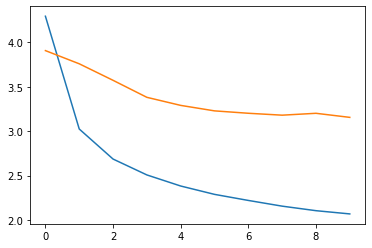

In [28]:
training_losses = np.genfromtxt(config['training_loss_path'])[2:]
validation_losses = np.genfromtxt(config['validation_loss_path'])[2:]

x_axis = []
for i in range(len(training_losses)):
    x_axis.append(i)

plt.figure()
plt.plot(x_axis, training_losses)
plt.plot(x_axis, validation_losses)

In [ ]:
# torch.save({
#         'model_state_dict': model.state_dict(),
#         'optimizer_state_dict': optimizer.state_dict(),
#     }, config['saved_path'])